In [1]:
import torch
import torch.nn as nn
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as pt
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import typing
from datetime import datetime

device = "cpu"

In [2]:
df = pd.read_csv("data.csv")
df.columns = ["Date", "Course"]
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic_increasing:
    df = df.sort_index()
df.dropna(axis=0, how="any", inplace=True)
print(df)

             Course
Date               
2015-01-01  56.2376
2015-01-13  62.7363
2015-01-14  64.8425
2015-01-15  66.0983
2015-01-16  64.8337
...             ...
2024-02-06  91.2434
2024-02-07  90.6842
2024-02-08  91.1514
2024-02-09  91.2561
2024-02-10  90.8901

[2237 rows x 1 columns]


In [3]:
def lags(df: DataFrame, n_lags: int) -> DataFrame:
    dfc = df.copy()
    for i in range(1, n_lags + 1):
        dfc[f"lag{i}"] = dfc["Course"].shift(i)
    dfc = dfc.iloc[n_lags:]
    return dfc


input_dim = 100

df_lags = lags(df, input_dim)
print(df_lags)

             Course     lag1     lag2     lag3     lag4     lag5     lag6  \
Date                                                                        
2015-06-06  56.2463  54.9908  53.0590  53.4413  52.8213  52.9716  52.2907   
2015-06-09  56.0435  56.2463  54.9908  53.0590  53.4413  52.8213  52.9716   
2015-06-10  55.9100  56.0435  56.2463  54.9908  53.0590  53.4413  52.8213   
2015-06-11  54.8219  55.9100  56.0435  56.2463  54.9908  53.0590  53.4413   
2015-06-12  54.5285  54.8219  55.9100  56.0435  56.2463  54.9908  53.0590   
...             ...      ...      ...      ...      ...      ...      ...   
2024-02-06  91.2434  90.6626  90.2299  89.6678  89.2887  89.6090  89.5159   
2024-02-07  90.6842  91.2434  90.6626  90.2299  89.6678  89.2887  89.6090   
2024-02-08  91.1514  90.6842  91.2434  90.6626  90.2299  89.6678  89.2887   
2024-02-09  91.2561  91.1514  90.6842  91.2434  90.6626  90.2299  89.6678   
2024-02-10  90.8901  91.2561  91.1514  90.6842  91.2434  90.6626  90.2299   

C:\Users\Sk1fix\AppData\Local\Temp\ipykernel_5028\3317197228.py:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [4]:
def feature_label_split(df: DataFrame, target_col: str) -> tuple[DataFrame]:
    """
        Separation of validation and training sets
    """
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y


def train_val_test_split(df: pd.DataFrame, target_col: str, test_ratio: float) -> tuple[pd.DataFrame]:
    """
        Separation of validation and training sets
    """
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    df_lags, 'Course', 0.2)
print(len(X_train))
print(len(X_test))
print(len(X_val))

1281
428
428


In [5]:
scaler = MinMaxScaler()
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

batch_size = 100

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size,
                          shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size,
                        shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size,
                         shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [6]:
class RNNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int, output_dim: int, dropout_prob: float) -> None:
        """
            The __init__ method that initiates an RNN instance
        """
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(
            0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [7]:
class Optimization:
    """
        Optimization is a helper class that allows training, validation, prediction
    """

    def __init__(self, model: RNNModel, loss_fn: torch.nn.modules.loss, optimizer: torch.optim.Optimizer) -> None:

        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x: torch.Tensor, y: torch.Tensor) -> float:
        """
            The method train_step completes one step of training
        """

        self.model.train()

        yhat = self.model(x)

        loss = self.loss_fn(y, yhat)

        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()

    def train(self, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, batch_size: int = 64, n_epochs: int = 50,
              n_features: int = 1):
        """
            The method train performs the model training
        """
        model_path = "output.pth"

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 10 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader: torch.utils.data.DataLoader, batch_size: int = 1, n_features: int = 1) -> list[float]:
        """
            The method evaluate performs the model evaluation
        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        """
        The method plots the calculated loss values for training and validation
        """
        pt.plot(self.train_losses, label="Training loss")
        pt.plot(self.val_losses, label="Validation loss")
        pt.legend()
        pt.title("Losses")
        pt.show()
        pt.close()

In [11]:
def df_graph(df: DataFrame, title: str) -> None:
    """ 
        Visualization of graphs
    """
    data = []
    value = go.Scatter(
        x=df.index,
        y=df.Course,
        mode="lines",
        name="Course",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)
    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Course", ticklen=5, zeroline=False),
    )
    fig = dict(data=data, layout=layout)
    iplot(fig)


df_graph(df, "Course change")

[1/100] Training loss: 0.2019	 Validation loss: 0.5328
[2/100] Training loss: 0.1055	 Validation loss: 0.3078
[3/100] Training loss: 0.0485	 Validation loss: 0.1688
[4/100] Training loss: 0.0250	 Validation loss: 0.1032
[5/100] Training loss: 0.0195	 Validation loss: 0.0830
[6/100] Training loss: 0.0202	 Validation loss: 0.0821
[7/100] Training loss: 0.0189	 Validation loss: 0.0855
[8/100] Training loss: 0.0189	 Validation loss: 0.0882
[9/100] Training loss: 0.0181	 Validation loss: 0.0877
[10/100] Training loss: 0.0175	 Validation loss: 0.0858
[20/100] Training loss: 0.0143	 Validation loss: 0.0756
[30/100] Training loss: 0.0095	 Validation loss: 0.0592
[40/100] Training loss: 0.0078	 Validation loss: 0.0458
[50/100] Training loss: 0.0055	 Validation loss: 0.0371
[60/100] Training loss: 0.0052	 Validation loss: 0.0327
[70/100] Training loss: 0.0048	 Validation loss: 0.0301
[80/100] Training loss: 0.0038	 Validation loss: 0.0269
[90/100] Training loss: 0.0035	 Validation loss: 0.0254
[

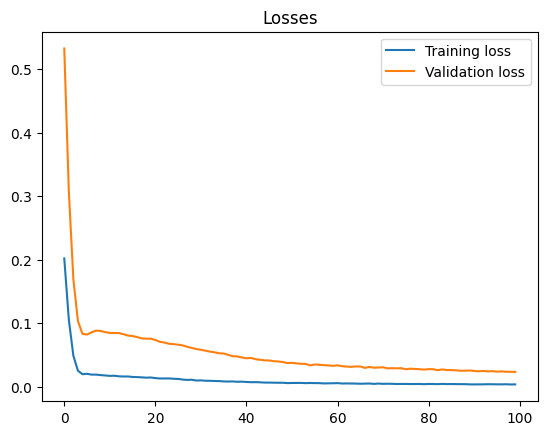

In [18]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
dropout = 0.2
n_epochs = 100
learning_rate = 1e-4
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim': hidden_dim,
                'layer_dim': layer_dim,
                'output_dim': output_dim,
                'dropout_prob': dropout}

model = RNNModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size,
          n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

In [25]:
def inverse_transform(scaler, df: DataFrame, columns: list) -> DataFrame:
    """
        Get the real values of the forecasts
    """
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions: list, values: list, df_test: DataFrame, scaler) -> DataFrame:
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = DataFrame(data={"course": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["course", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)

def get_value_by_month(df: DataFrame, start_date: str, end_date: str) -> DataFrame:
    """
        Getting the course in the specified period
    """
    df = df.reset_index(inplace=False)
    start_date = pd.to_datetime(start_date, format='%Y-%m-%d')
    end_date = pd.to_datetime(end_date, format='%Y-%m-%d')
    return df[(start_date <= df["Date"]) & (df["Date"] <= end_date)]

get_value_by_month(df_result, "2020-01-10", "2020-02-10")

,Date,course,prediction
